In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely import wkt
from shapely.validation import make_valid
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn import cluster
import geopandas
from scipy.stats import zscore

# Data driven regions: Geo+Demographical information

A while back, Nate Silver tweeted his attempt to divide the US into a series of regions [tweet](https://twitter.com/NateSilver538/status/1199686800752726025?s=20&t=9HRz_7h-jve4Esk7mMoKjQ). He didn't describe his methods, but they seemed in part data driven and in part subjective. See [Jeremy Posada's website](https://jeremyposadas.org/regions/) for another interesting attempt at this problem.

Since then, I've been interested in finding a better way to define regions. The categories people largely use now (Midwest, northeast / New England, etc.) affect our perception of how related certain areas are to each other, but what if they don't reflect the actual relatedness of the areas? For example, I live near the southern tier of New York, and it can feel a lot like the midwest, but since it's in New York, it's considered the northeast. 

Here, I will attempt to define regions in a data driven way. Specifically, I believe regions should reflect not only geography, but the people in each region. Therefore, to define regions, I'll use both geographical and demographical information, obtained from [this dataset](https://www.kaggle.com/datasets/roche-data-science-coalition/uncover).

This notebook attempts to cluster the counties of the continental US into regions, using geographical and or demographical data. 

First, I'll read in and format the data:

In [2]:
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
# region_data = pd.read_excel(r'G:\My Drive\ds_projects\URAmericaMapCountyList.xlsx', skiprows=3, header=0)
county_data.head(5)

,geometry,st,state,st_abbr,county,fips,location,area_sqmi,e_totpop,m_totpop,...,f_theme4,f_total,e_uninsur,m_uninsur,ep_uninsur,mp_uninsur,e_daypop,objectid,shape_are,shape_len
0,"POLYGON ((-86.9212008685 32.6575481071, -86.92...",1,ALABAMA,AL,Autauga,1001,"Autauga County, Alabama",594.446120,55049,0,...,f,f,4852,649,8.9,1.2,40854,1,0.150260,2.052636
1,"POLYGON ((-86.963362945 33.8582273591, -86.959...",1,ALABAMA,AL,Blount,1009,"Blount County, Alabama",644.806508,57704,0,...,f,f,6388,740,11.2,1.3,42597,2,0.164406,2.392672
2,"POLYGON ((-85.5934395044 32.8972732071, -85.59...",1,ALABAMA,AL,Chambers,1017,"Chambers County, Alabama",596.531112,34018,0,...,f,f,3979,544,11.8,1.6,27940,3,0.150587,1.714193
3,"POLYGON ((-86.1963696041 31.4254368653, -86.19...",1,ALABAMA,AL,Coffee,1031,"Coffee County, Alabama",678.985652,50991,0,...,f,f,5253,464,10.7,0.9,47236,4,0.167192,1.678611
4,"POLYGON ((-88.1392513191 34.5878014617, -88.13...",1,ALABAMA,AL,Colbert,1033,"Colbert County, Alabama",592.619664,54377,0,...,f,f,4932,458,9.1,0.8,56227,5,0.158869,2.175068


In [3]:
county_data['geometry'] = county_data['geometry'].apply(wkt.loads)
county_data = geopandas.GeoDataFrame(county_data)

In [4]:
# Convert r Polygon text to shapely polygon
for row_idx, row in county_data.iterrows():
    points = re.findall(r'-?\d+.\d+', row['geometry'].wkt)
    i = 0
    list_points = []
    while i < len(points):
        list_points.append((float(points[i]), float(points[i+1])))
        i+=2
    list_points

    county_shape = Polygon(list_points)
    county_center = county_shape.centroid
    center_points = re.findall(r'-?\d+.\d+', county_center.wkt)
    county_data.at[row_idx, 'center_long'] = float(center_points[0])
    county_data.at[row_idx, 'center_lat'] = float(center_points[1])

<AxesSubplot:>

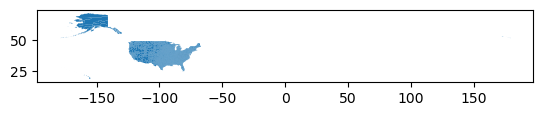

In [47]:
county_data.plot()

Let's drop the data outside the continental US. We can do this by eyeballing the coordinates.

<AxesSubplot:>

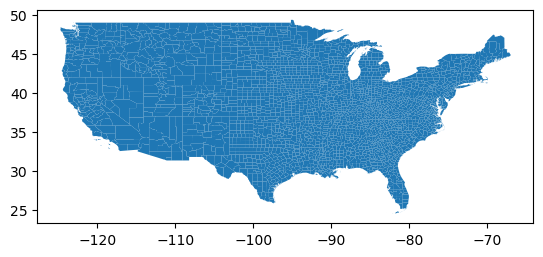

In [48]:
#Drop data from outside the continental US
county_data = county_data[county_data['center_long']<-50]
county_data = county_data[county_data['center_long']>-125]
county_data = county_data[county_data['center_lat']<50]
# sns.scatterplot(county_data, x='center_long', y='center_lat', s=1)
county_data.plot()

## Geographic clustering

First, I'll cluster based off of only location (latitude and longitude). 

<AxesSubplot:>

<Figure size 1100x1000 with 0 Axes>

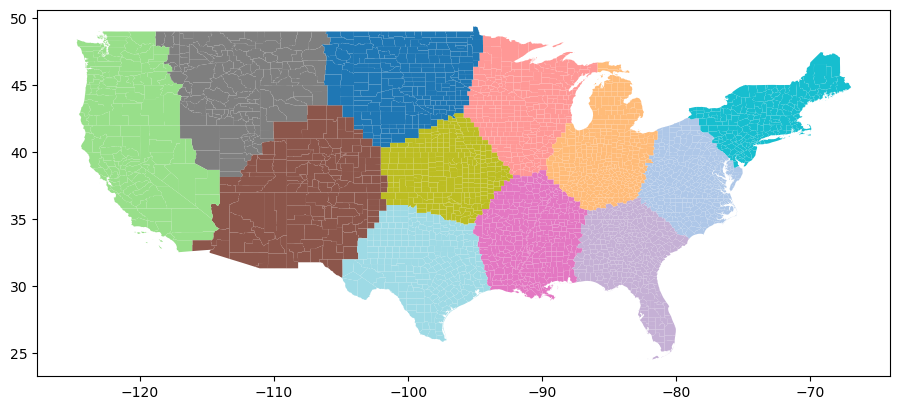

In [49]:
# What if we cluster just based off location?
X = county_data[['center_long', 'center_lat']]
n_regions = 12
kmeans = cluster.KMeans(n_clusters=n_regions, random_state=2022)
kmeans.fit(X)
county_data['KMeans_cluster'] = kmeans.labels_
plt.figure(figsize=(11,10))
county_data.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))

Let's also cluster with n_clusters=48, to see how the algorithm would design states for the continental US.

<AxesSubplot:>

<Figure size 1100x1000 with 0 Axes>

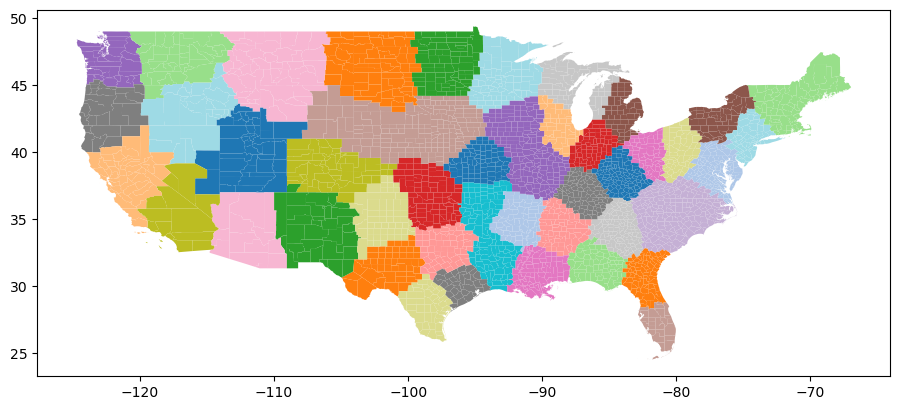

In [50]:
# Let's make states
kmeans = cluster.KMeans(n_clusters=48, random_state=2022)
kmeans.fit(X, sample_weight=county_data['e_totpop'])
# kmeans.fit(X)
county_data['KMeans_cluster'] = kmeans.labels_
plt.figure(figsize=(11,10))
county_data.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))

## Demographic clustering

These are simple geographic clustering of counties. However, boundaries of regions (in states, countries, etc) are not only defined by geography, but by people, or culture. Let's try to define regions by demographic information only -- this is of course a bit extreme, as regions are mostly geographical, but this will help us see how much this demographic information is tied to geography itself. To do so, we'll use the summary measures of a [CDC dataset](https://www.kaggle.com/datasets/roche-data-science-coalition/uncover), including measures describing socioeconomic status (rpl_theme1), household characteristics (rpl_theme2), racial and ethnic minority status (rpl_theme3), and housing type + transportation (rpl_theme4).

<AxesSubplot:>

<Figure size 1100x1000 with 0 Axes>

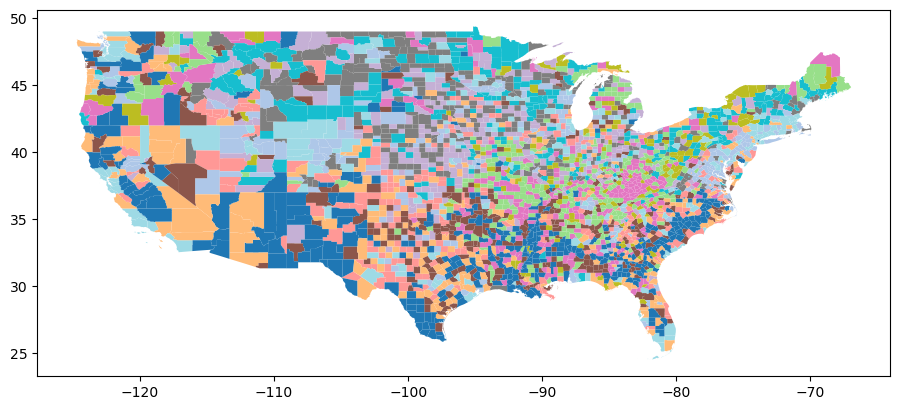

In [51]:
# Try defining regions by demographics only
X = county_data[['rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4']]
X = X.apply(zscore)
n_regions = 12
kmeans = cluster.KMeans(n_clusters=n_regions, random_state=2022)
# kmeans = cluster.AgglomerativeClustering(n_clusters=n_regions)

kmeans.fit(X)
county_data['KMeans_cluster'] = kmeans.labels_
plt.figure(figsize=(11,10))
county_data.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))

Though the regions are obviously very scattered geographically, they are definitely related to geography: some colors appear more often in certain areas (pink around Kentucky / West Virginia, blue in the south).

Now, let's try including both the demographics and geography of each county in our clustering algorithm.

<AxesSubplot:>

<Figure size 1100x1000 with 0 Axes>

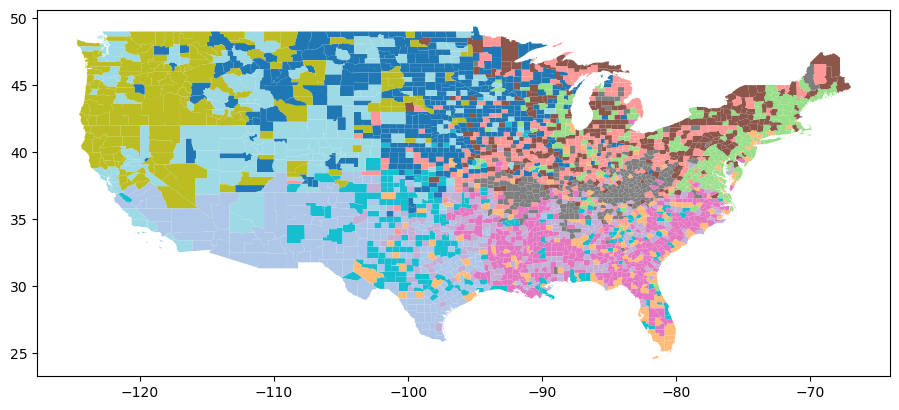

In [52]:
# Include other factors in creating regions

X = county_data[['center_long', 'center_lat', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4']]
X = X.apply(zscore)
n_regions = 12
kmeans = cluster.KMeans(n_clusters=n_regions, random_state=2022)
kmeans.fit(X)
county_data['KMeans_cluster'] = kmeans.labels_
plt.figure(figsize=(11,10))
county_data.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))

Now, are clusters are more geographically centered, and you can start to imagine some general regional boundaries. Still, the clusters are mixed geographically, and regions should in practice be geographically continuous. 

One solution to this problem is to input the cluster centers from this output as the intial state for a new kmeans algorithm that again clusters based off location.

<AxesSubplot:>

<Figure size 1100x1000 with 0 Axes>

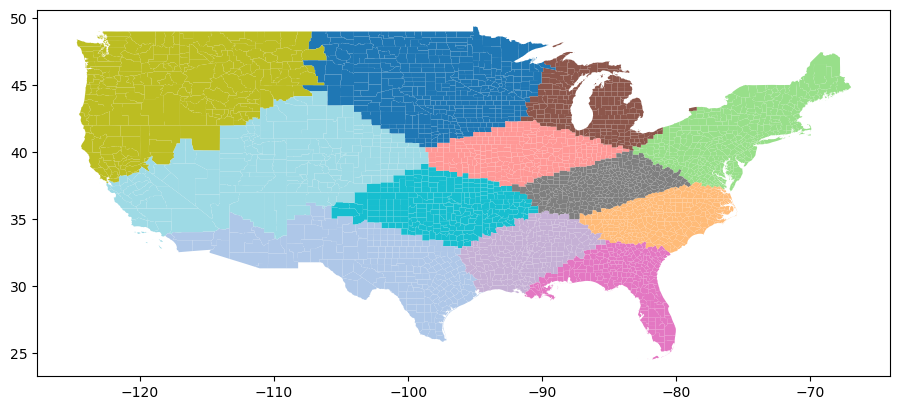

In [53]:
# Now, input these cluster centers and recluster based off only location (easy solution)
X = county_data[['center_long', 'center_lat']]
X = X.apply(zscore)
n_regions = 12
kmeans = cluster.KMeans(n_clusters=n_regions, random_state=2022, init=kmeans.cluster_centers_[:,:2], max_iter=1, n_init=1)
kmeans.fit(X)
county_data['KMeans_cluster'] = kmeans.labels_
plt.figure(figsize=(11,10))
county_data.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))

This certainly makes the regions geographically continuous, but the borders of each region are now defined again entirely by geography. 

Another solution to this problem arises from defining the problem concretely. I'd argue the biggest problem with the regions generated from demographic data is many counties are geographically isolated from other counties in the same region -- they form little dots of color by being completely surrounded by other regions. These counties should really be defined by the region they are surrounded by (or, when they are adjacent to multiple regions, the region they are most connected to).

Therefore, to try to salvage this regional classification, I'd like to redefine counties that are completely separated (non-adjacent) from other counties in the region to belong to the region they are actually most adjacent to. To do so, I've written the function merge_connected_counties. The function takes advantage of geopandas to merge counties that are from the same region and adjacent. Counties that are geographically separate from their region are redefined by whichever region they are most connected to*. We can do this indefinitely by merging merged counties, until the merged counties contain a number of counties set by min_threshold. 

*I've written a few functions (below) to define the 'most connected cluster'. I've found my original function, most_connected_cluster, to work the best

In [54]:
# (Optional: save or read in the data)
# county_data.to_pickle(r'C:\Users\mgm24\Documents\datasets\county_data.pkl')
# county_data = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\county_data.pkl')

In [55]:
def most_connected_cluster(neighbors):
    """
    Returns the most common cluster (region) of the county's neighbors
        Neighbors: the counties sharing a border with the county 
    """
    clusters = np.unique(neighbors.KMeans_cluster)
    if len(clusters) > 0:
        max_adj_clust = 0
        for cluster in clusters:
            num_adj = np.sum(neighbors['KMeans_cluster']==cluster) 
            if num_adj > max_adj_clust:
                max_adj_clust = num_adj
                conn_clust = cluster
        return conn_clust
    else:
        raise 'error'

In [56]:
# Alternative method
def find_next_nearest_center(county_center, clust_centers, cluster):
    """Returns the cluster with the smallest euclidean distance to the county """
    min_dist = 1000
    for i, clust_center in enumerate(clust_centers):
        dist = ((county_center[0] - clust_center[0])**2 + (county_center[1] - clust_center[1])**2)**.5
        if dist < min_dist and not i==cluster:
            min_dist = dist
            closest_cluster = i
    return closest_cluster

In [57]:
# Another alternative method
def highestborder_cluster(neighbors):
    """Returns the cluster of the county with the longest border with the county"""
    intersections = neighbors.geometry.intersection #find the length of the intersection
    lengths = intersections(x.geometry).length
    max_border_neighbor = neighbors.iloc[np.argmax(lengths)]
    return max_border_neighbor['KMeans_cluster']

In [58]:
def merge_connected_counties(county_data, min_counties):
    """The function takes advantage of geopandas to merge counties that are from the same region and adjacent.
    Counties that are geographically separate from their region are redefined by whichever region they are most connected to. 
    This runs iteratively until the merged counties contain a number of counties set by min_threshold. """
    new_df = county_data.copy()
    new_df['Merge_complete'] = False
    new_df['n_counties'] = 1
    while np.sum(new_df['Merge_complete']) < new_df.shape[0]: #No isolated counties
#         new_df.plot('KMeans_cluster', cmap='tab20')
        print('---------------------------------------------')
        print(np.sum(new_df['Merge_complete']) / new_df.shape[0]) 
        print('---------------------------------------------')
        i = 0
        counties_tomerge = new_df[new_df['Merge_complete']==False]
        curr_min_counties = np.min(counties_tomerge['n_counties'])
        county = counties_tomerge[counties_tomerge['n_counties']==curr_min_counties].iloc[0]
        
        if county['Merge_complete']==False:
            index = county.name
            neighbors = new_df[~new_df.geometry.disjoint(county.geometry)]
#             intersections = neighbors.geometry.intersection #find the length of the intersection
#             lengths = intersections(x.geometry).length
#             ratios = lengths / x.geometry.length
#             neighbors = neighbors[ratios>.1] #only take neighbors with borders greater than 10% of overall border    
            neighbors = neighbors[neighbors['KMeans_cluster']==county['KMeans_cluster']]
            
            if neighbors.shape[0] > 1: #adjacent to at least 1 other county in same cluster
                new_df.at[index, 'geometry'] = neighbors.unary_union
                new_df.at[index, 'n_counties'] += np.sum(neighbors['n_counties'])
                neighbors = neighbors[neighbors['fips']!=county['fips']]
                if new_df.at[index, 'n_counties'] >= min_counties:
                    new_df.at[index, 'Merge_complete'] = True
                new_df = new_df.drop(neighbors.index, axis='index')

            else:
#                 next_nearest = find_next_nearest_center([county['center_long'], county['center_lat']], kmeans.cluster_centers_, county['KMeans_cluster'])
#                 new_df['KMeans_cluster'] = next_nearest
                neighbors = new_df[~new_df.geometry.disjoint(county.geometry)]
                neighbors = neighbors[neighbors['fips']!=county['fips']]
#                 intersections = neighbors.geometry.intersection #find the length of the intersection
#                 lengths = intersections(x.geometry).length
#                 ratios = lengths / x.geometry.length
#                 neighbors = neighbors[ratios>.1] #only take neighbors with borders greater than 10% of overall border
                if len(neighbors)>0:
#                     pre_flip = county['KMeans_cluster']
#                     post_flip = most_connected_cluster(neighbors)
                    new_df.at[index,'KMeans_cluster'] = most_connected_cluster(neighbors)
#                     new_df.at[index,'KMeans_cluster'] = highestborder_cluster(neighbors)

                else: #not adjacent to any other counties (island)
                    new_df.at[index,'Merge_complete'] = True
            
    return new_df
    

<AxesSubplot:>

<Figure size 1100x1000 with 0 Axes>

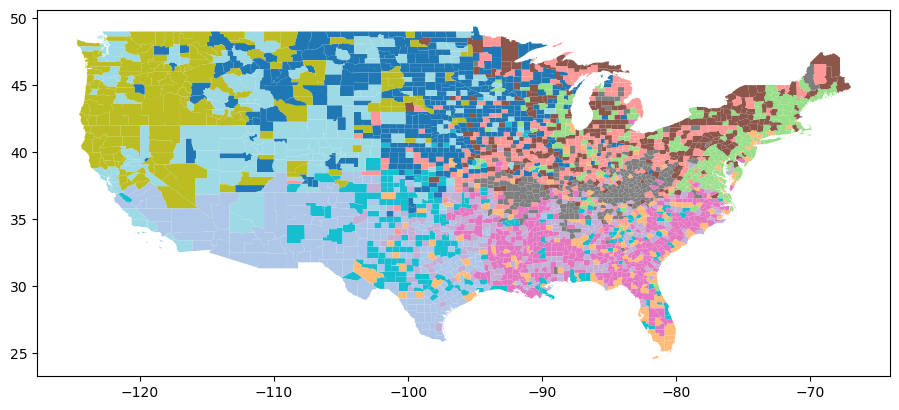

In [59]:
# Re-run geo+demo clustering

X = county_data[['center_long', 'center_lat', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4']]
X = X.apply(zscore)
n_regions = 12
kmeans = cluster.KMeans(n_clusters=n_regions, random_state=2022)
kmeans.fit(X)
county_data['KMeans_cluster'] = kmeans.labels_
plt.figure(figsize=(11,10))
county_data.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))

In [60]:
# WARNING runtime is very long. 
# For various cluster sizes, merge the data. 
county_data.geometry = county_data.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1)

merged_data_7 = merge_connected_counties(county_data, 7)
merged_data_20 = merge_connected_counties(county_data, 20)
merged_data_50 = merge_connected_counties(county_data, 50)
merged_data_100 = merge_connected_counties(county_data, 100)
merged_data_200 = merge_connected_counties(county_data, 200)
merged_data_500 = merge_connected_counties(county_data, 500)
merged_data_1000 = merge_connected_counties(county_data, 1000)
merged_data_2000 = merge_connected_counties(county_data, 2000)

# merged_data_7.to_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_7b.pkl')
# merged_data_20.to_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_20b.pkl')
# merged_data_50.to_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_50b.pkl')
# merged_data_100.to_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_100b.pkl')
# merged_data_200.to_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_200b.pkl')
# merged_data_500.to_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_500b.pkl')
# merged_data_1000.to_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_1000b.pkl')
# merged_data_2000.to_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_2000b.pkl')

C:\Users\mgm24\anaconda3\envs\DS_projects\lib\site-packages\pandas\core\dtypes\cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [61]:
# Read in merge data 

# merged_data_7 = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_7b.pkl')
# merged_data_20 = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_20b.pkl')
# merged_data_50 = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_50b.pkl')
# merged_data_100 = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_100b.pkl')
# merged_data_200 = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_200b.pkl')
# merged_data_500 = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_500b.pkl')
# merged_data_1000 = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_1000b.pkl')
# merged_data_2000 = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\merged_data_2000b.pkl')

Text(0.5, 1.0, 'Merge size=2000')

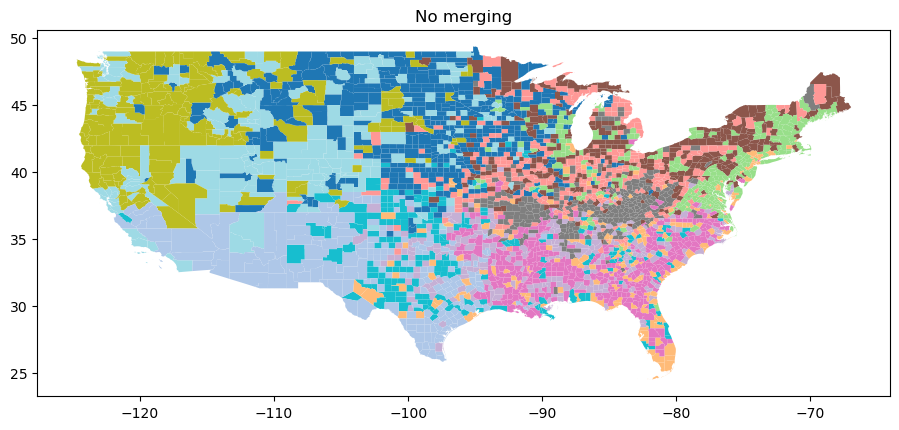

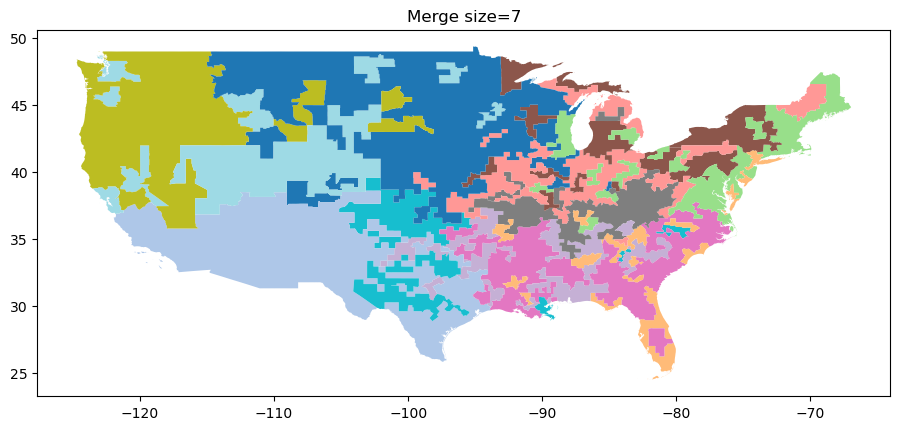

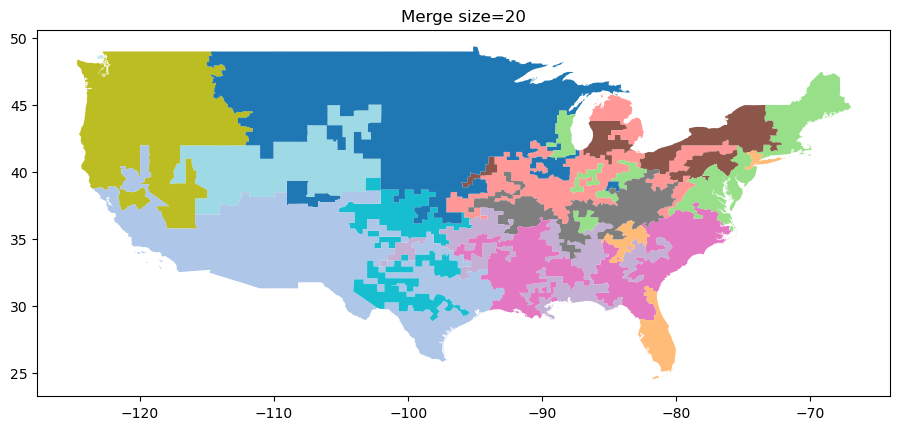

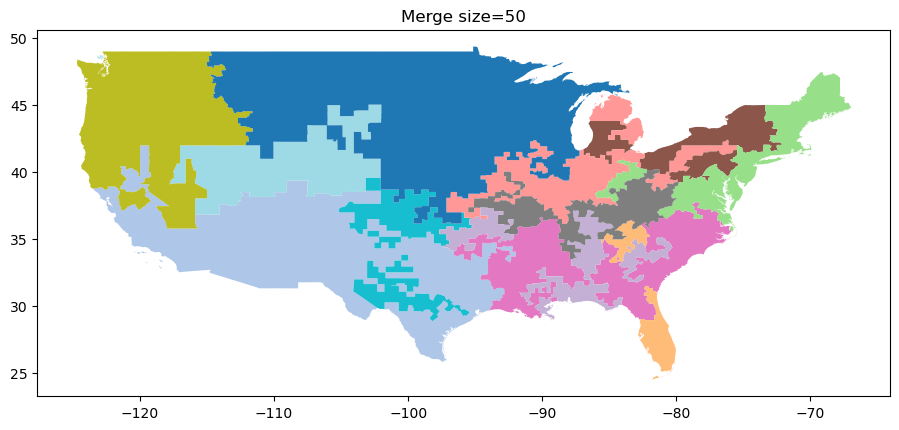

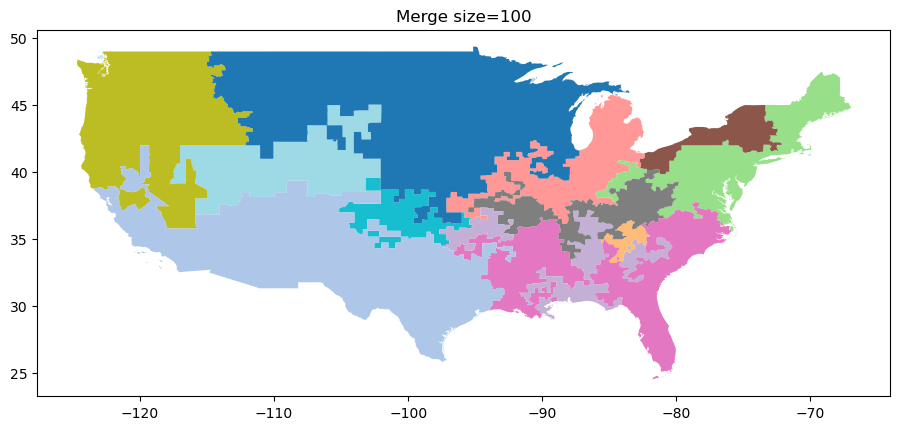

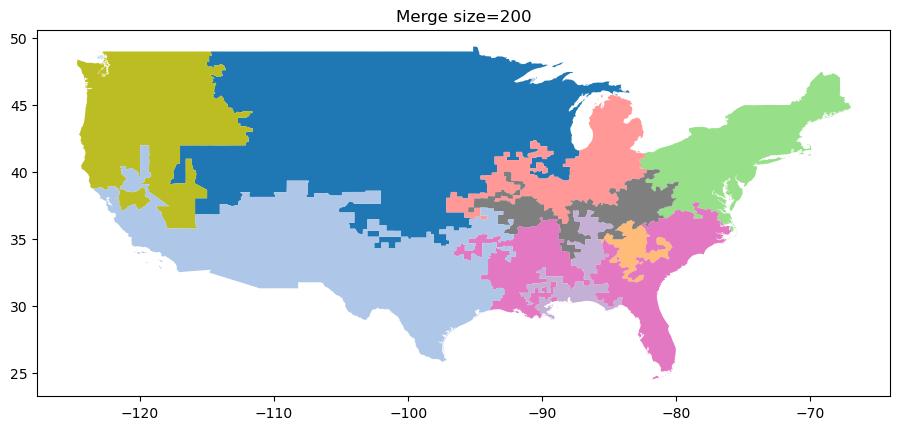

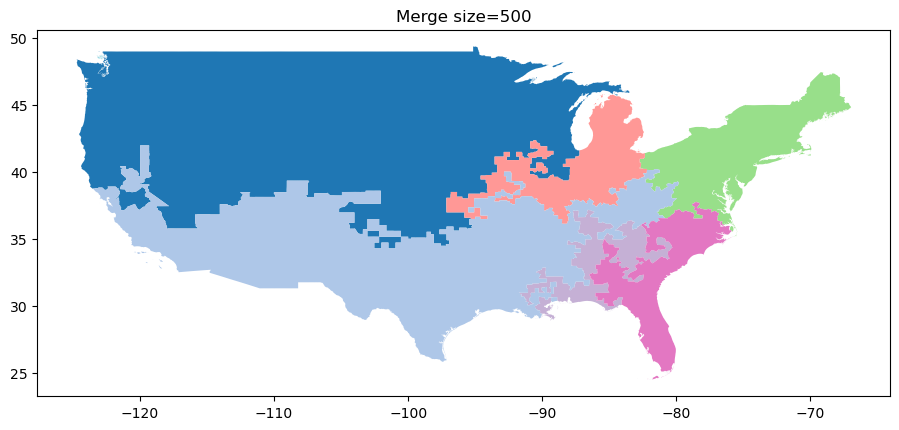

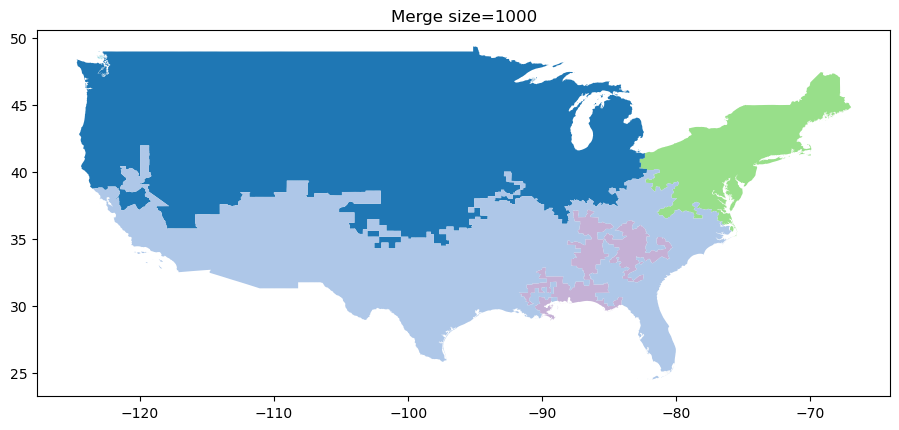

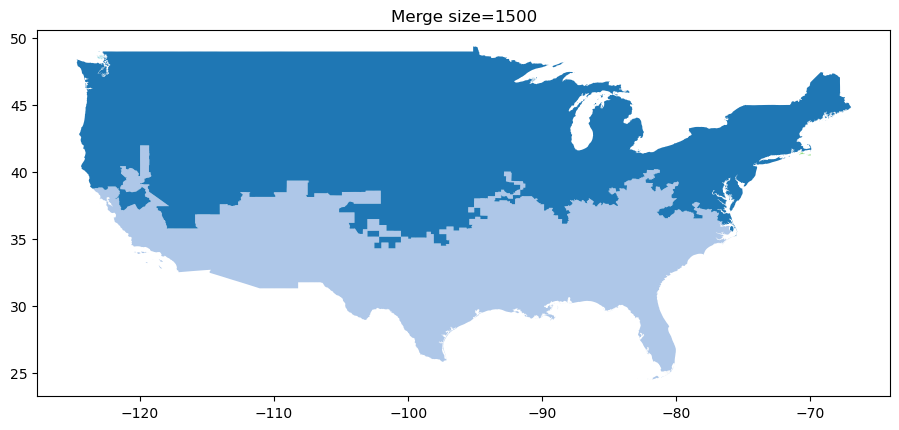

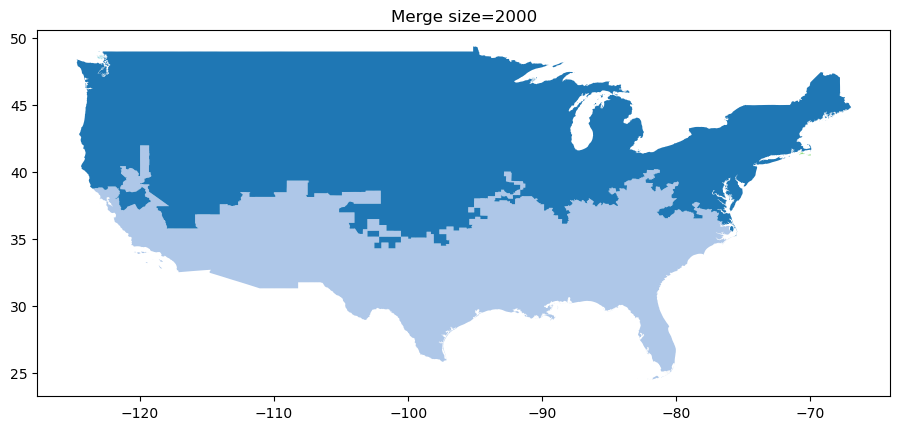

In [62]:
# Plot merged data, for each merge size
county_data.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('No merging')
merged_data_7.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=7')
merged_data_20.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=20')
merged_data_50.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=50')
merged_data_100.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=100')
merged_data_200.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=200')
merged_data_500.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=500')
merged_data_1000.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=1000')
merged_data_1500.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=1500')
merged_data_2000.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=2000')

This method certainly isn't perfect. Regions can be very 'patchy', snaking through other regions rather than forming a general blob. But regions are now (mostly) spatially continuous, so it's an improvement on what we had before. 

I'll plot a couple of my favorite cluster sizes:

Text(0.5, 1.0, 'Merge size=100')

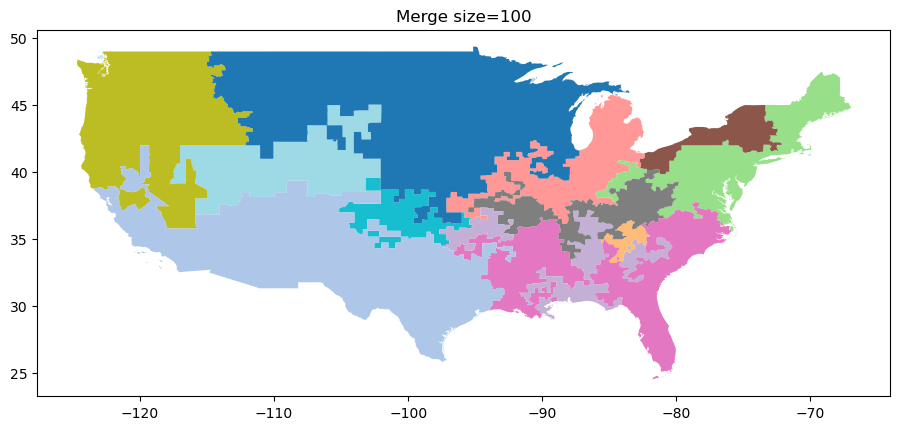

In [63]:
merged_data_100.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=100')

I love the brown region, capturing upstate New York, and snaking along Lake Erie. But there are still several regions that look like a random patchwork of counties.

Text(0.5, 1.0, 'Merge size=500')

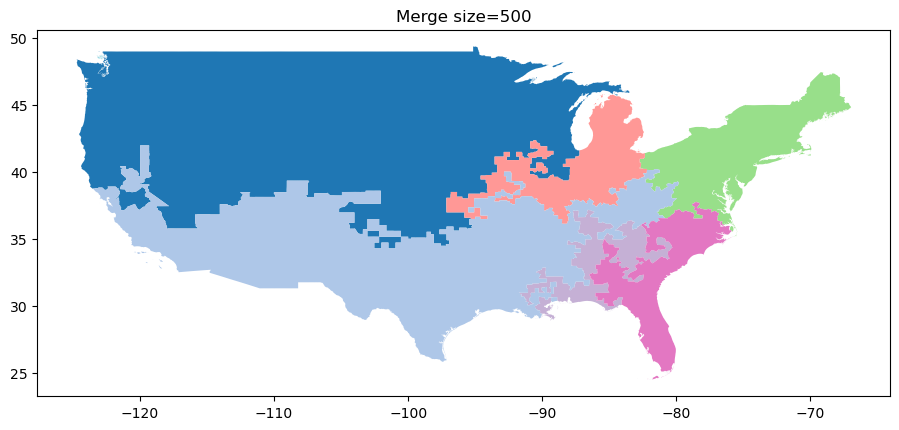

In [64]:
merged_data_500.plot('KMeans_cluster', cmap='tab20', figsize=(11,10))
plt.title('Merge size=500')

Here, some regions are relatively continuous, and make subjective sense to me. Still, the light and dark blue regions are much bigger than the others, demonstrating a problem with the algorithm.

## Conclusion

Overall, we can get some interesting results defining regions using data. The method I use here is limited; the data used to describe the similarity of different communities is only a few metrics describing health, diversity, etc. So more data, describing certain culural comminalities (preferred sports teams? voting data? nearest city?) would be helpful. 

Alternatively, it might be better to define regions based off how close the people are in each county. It turns out meta has an excellent dataset that does a pretty good job capturing this, [measuring what proportion of facebook friends are found between counties](https://dataforgood.facebook.com/dfg/tools/social-connectedness-index). For attempt at this same problem using this dataset, see the FB_network_connectivity script.